In [3]:
import os
import cv2
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Add, Concatenate, Activation, BatchNormalization, MaxPooling2D, Input, DepthwiseConv2D, Lambda, LeakyReLU, Reshape, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Dropout, Flatten
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import Loss
from keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
import keras.backend as K
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# Data set generation and data enhancement

In [4]:
train_dir = '../dsForBinary/train'
validation_dir = '../dsForBinary/validation'
test_dir = '../dsForBinary/test'

def preprocessing_function(image):
    def bilateral_filter(image):
        return cv2.bilateralFilter(image, d=21, sigmaColor=10, sigmaSpace=10)
    filtered_image = tf.numpy_function(bilateral_filter, [image], tf.float32)
    filtered_image.set_shape(image.shape)
    return filtered_image


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15,
    fill_mode='nearest',
    preprocessing_function=preprocessing_function
)
validation_datagen = ImageDataGenerator(rescale=1.0/255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15,
    fill_mode='nearest',
    # preprocessing_function=preprocessing_function
    )
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2179 images belonging to 2 classes.
Found 548 images belonging to 2 classes.
Found 552 images belonging to 2 classes.


2023-12-12 23:00:22.058653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 23:00:22.067697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 23:00:22.068005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

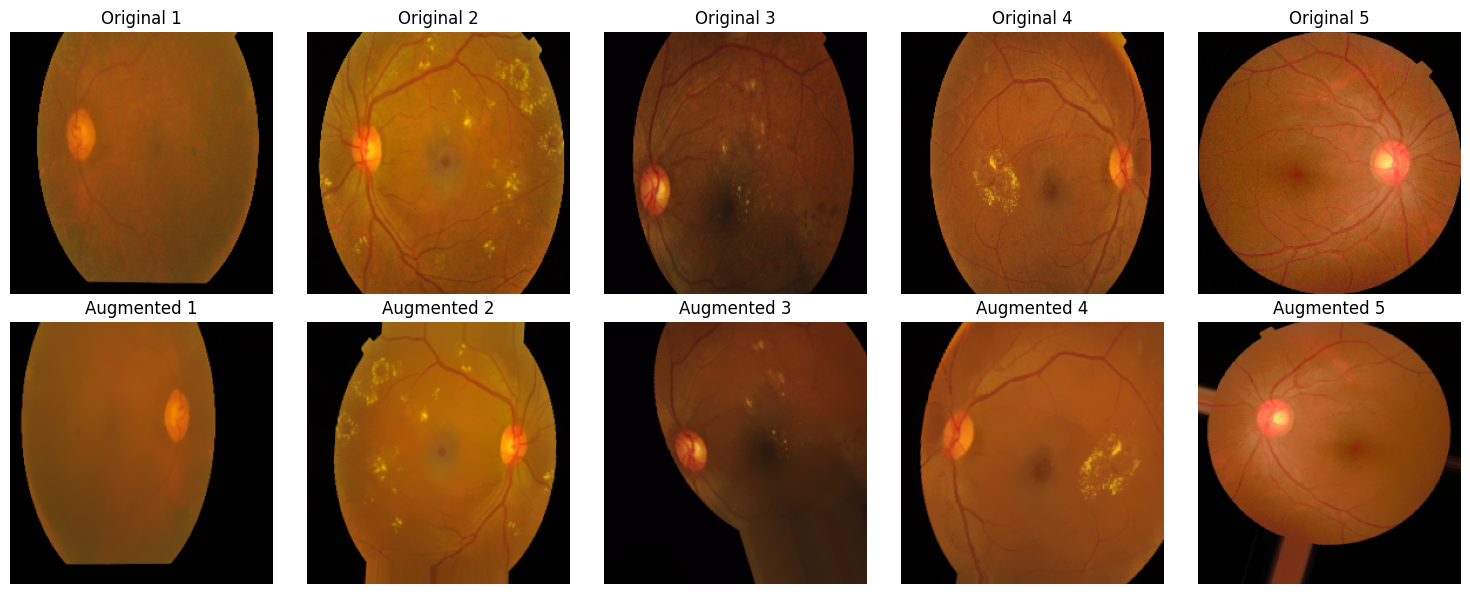

In [5]:
def display_image_augmentation_horizontal(original_gen, augmentation_gen, num_samples=5):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        original_img = next(original_gen)[0][0]
        if np.max(original_img) <= 1:
            original_img = (original_img * 255).astype('uint8')

        axs[0, i].imshow(original_img)
        axs[0, i].set_title(f'Original {i+1}')
        axs[0, i].axis('off')

        augmented_img = next(augmentation_gen.flow(np.expand_dims(original_img, 0), batch_size=1))[0]
        augmented_img = (augmented_img * 255).astype('uint8')

        axs[1, i].imshow(augmented_img)
        axs[1, i].set_title(f'Augmented {i+1}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_image_augmentation_horizontal(test_generator, train_datagen, num_samples=5)


# Creating models and attention mechanisms

# Model fitting

In [6]:
def create_model(base_model, num_classes=2, train_base_model=False):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    if not train_base_model:
        for layer in base_model.layers:
            layer.trainable = False
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])
    return model

inceptionv3_model = create_model(InceptionV3(weights='imagenet', include_top=False), train_base_model=False)

87910968/87910968 [==============================] - 7s 0us/step


In [7]:
def train_model(model, train_data, val_data, epochs=50):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1
    )
    return history

In [8]:
inceptionv3_history = train_model(inceptionv3_model, train_generator, validation_generator)

Epoch 1/50


2023-12-12 23:00:39.975637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-12 23:00:40.720893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-12 23:00:41.259851: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fba5d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 23:00:41.259889: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-12 23:00:41.265104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-12 23:00:41.389492: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - 101s 1s/step - loss: 0.4000 - accuracy: 0.8426 - auc: 0.9110 - precision: 0.8426 - recall: 0.8426 - val_loss: 0.3195 - val_accuracy: 0.8577 - val_auc: 0.9381 - val_precision: 0.8577 - val_recall: 0.8577
Epoch 2/50
69/69 [==============================] - 95s 1s/step - loss: 0.2552 - accuracy: 0.9018 - auc: 0.9599 - precision: 0.9018 - recall: 0.9018 - val_loss: 0.3121 - val_accuracy: 0.8558 - val_auc: 0.9421 - val_precision: 0.8558 - val_recall: 0.8558
Epoch 3/50
69/69 [==============================] - 95s 1s/step - loss: 0.2406 - accuracy: 0.9091 - auc: 0.9639 - precision: 0.9091 - recall: 0.9091 - val_loss: 0.2727 - val_accuracy: 0.8869 - val_auc: 0.9559 - val_precision: 0.8869 - val_recall: 0.8869
Epoch 4/50
69/69 [==============================] - 95s 1s/step - loss: 0.2513 - accuracy: 0.9009 - auc: 0.9615 - precision: 0.9009 - recall: 0.9009 - val_loss: 0.3134 - val_accuracy: 0.8704 - val_auc: 0.9441 - val_precision: 0.8704 - val_recall: 0

In [9]:
evaluation_result = inceptionv3_model.evaluate(test_generator)

18/18 [==============================] - 2s 94ms/step - loss: 0.1376 - accuracy: 0.9511 - auc: 0.9879 - precision: 0.9511 - recall: 0.9511


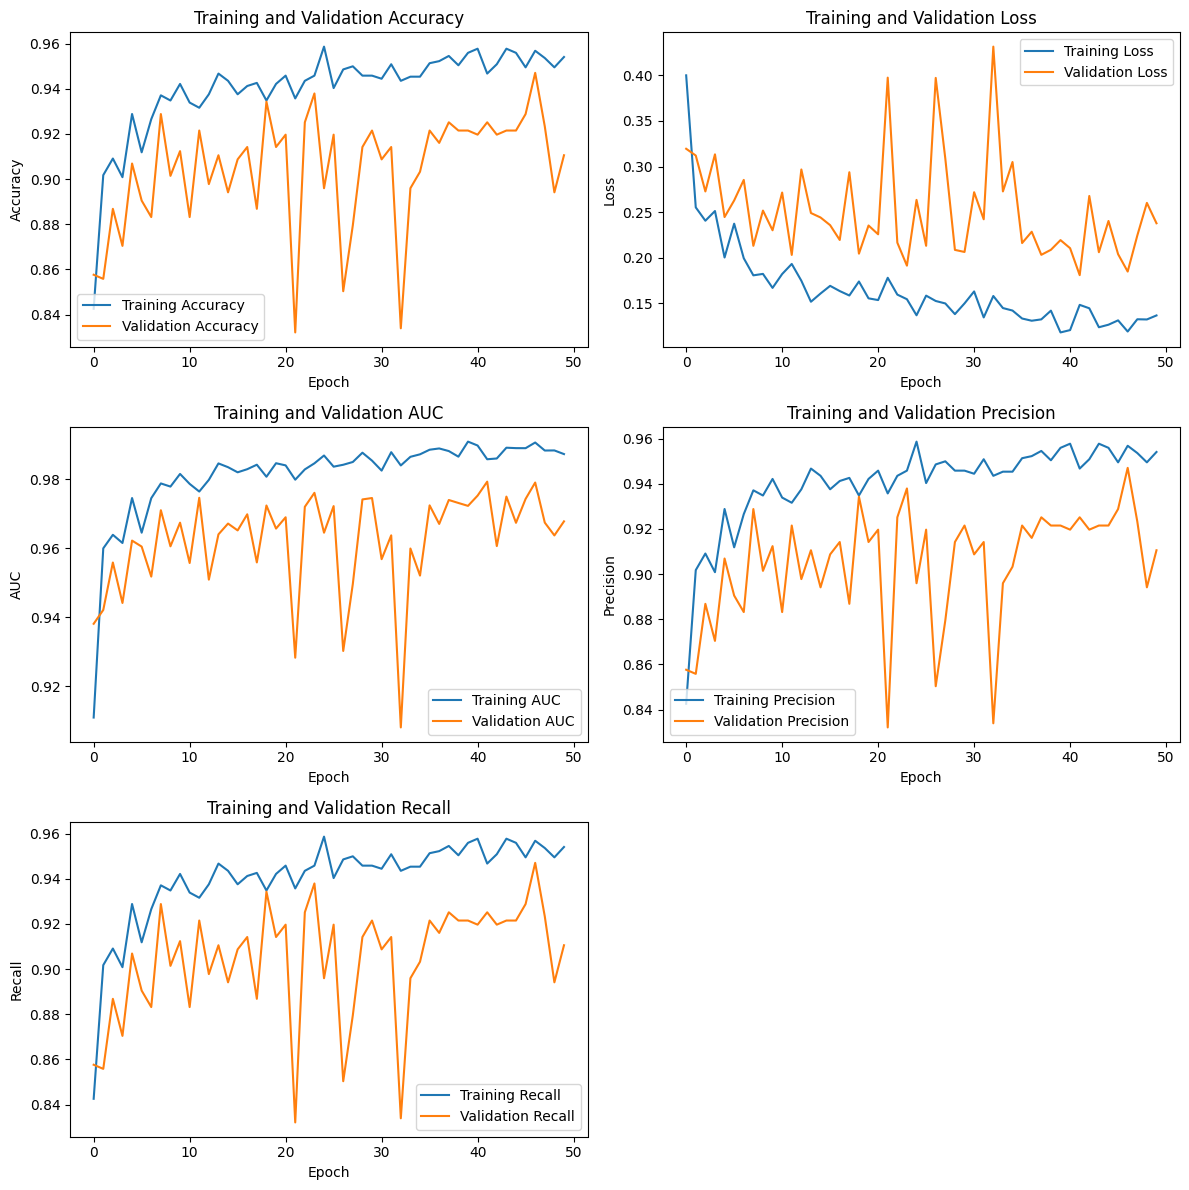

In [11]:
def plot_metrics(epochs, train_metric, val_metric, subplot_title, y_label):
    plt.plot(epochs, train_metric, label='Training ' + y_label)
    plt.plot(epochs, val_metric, label='Validation ' + y_label)
    plt.title(subplot_title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend()

metrics = {
    'Accuracy': ('accuracy', 'val_accuracy'),
    'Loss': ('loss', 'val_loss'),
    'AUC': ('auc', 'val_auc'),
    'Precision': ('precision', 'val_precision'),
    'Recall': ('recall', 'val_recall')
}

epochs = range(len(inceptionv3_history.history['accuracy']))

plt.figure(figsize=(12, 12))

for i, (metric_name, (train_key, val_key)) in enumerate(metrics.items(), 1):
    plt.subplot(3, 2, i)
    plot_metrics(epochs, inceptionv3_history.history[train_key], inceptionv3_history.history[val_key], f'Training and Validation {metric_name}', metric_name)

plt.tight_layout()
plt.show()

In [12]:
inceptionv3_model.save(r'model_inceptionv3.h5')

loaded_model = tf.keras.models.load_model(r'model_inceptionv3.h5')

evaluation_result = loaded_model.evaluate(test_generator)

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 3s 58ms/step - loss: 0.1376 - accuracy: 0.9511 - auc: 0.9879 - precision: 0.9511 - recall: 0.9511


17/17 [==============================] - 1s 18ms/step


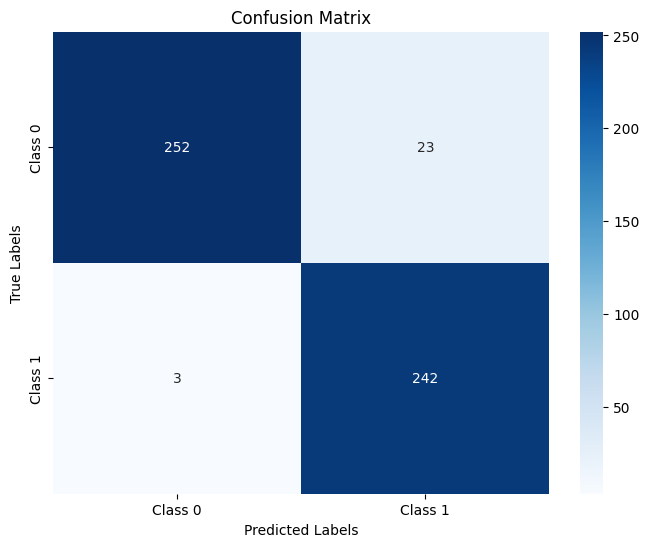

In [13]:
all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)
predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

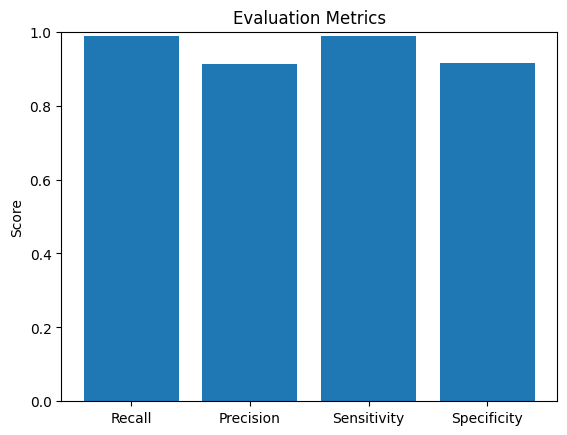

0.9877551020408163 0.9132075471698113 0.9877551020408163 0.9163636363636364


In [14]:
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

recall = TP / (TP + FN)
precision = TP / (TP + FP)
sensitivity = recall
specificity = TN / (TN + FP)

plt.bar(['Recall', 'Precision', 'Sensitivity', 'Specificity'], [recall, precision, sensitivity, specificity])
plt.ylim([0, 1])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()

print(recall, precision, sensitivity, specificity)

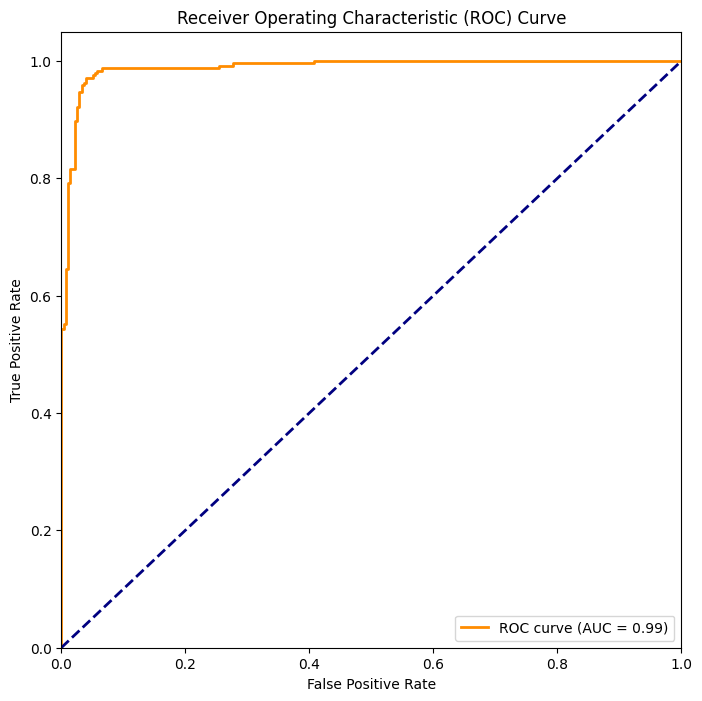

In [15]:
predicted_labels = np.argmax(predictions, axis=1)
fpr, tpr, thresholds = roc_curve(all_true_labels, predictions[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

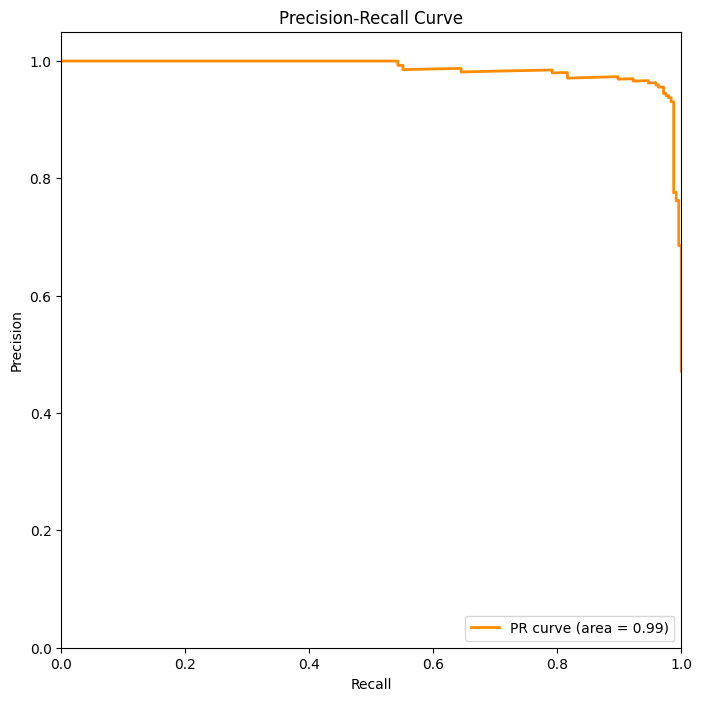

In [16]:
precision, recall, _ = precision_recall_curve(all_true_labels, predictions[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
# plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


In [17]:
f1 = f1_score(all_true_labels, predicted_labels)

print("F1 Score:", f1)

F1 Score: 0.9490196078431372


In [19]:
kappa_score = cohen_kappa_score(all_true_labels, predicted_labels)

# Print the Kappa score
print("Kappa Score:", kappa_score)

Kappa Score: 0.9001108237901736


In [20]:
history_df1 = pd.DataFrame(inceptionv3_history.history)

history_df1.to_csv('inceptionv3_history.csv', index=False)

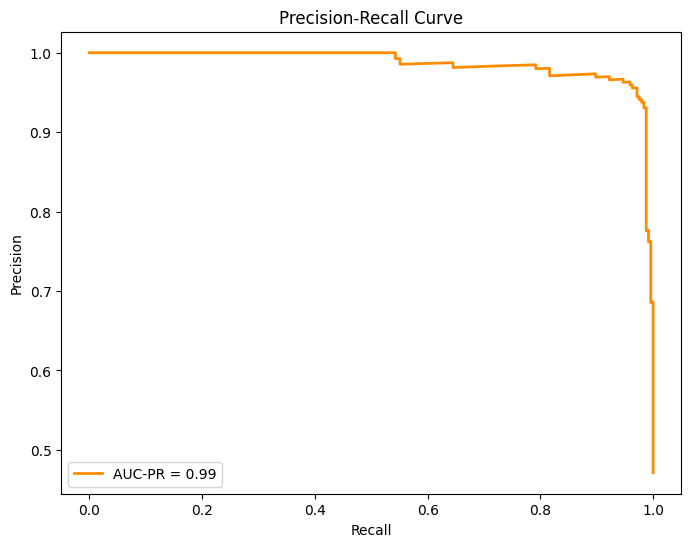

In [21]:
precision, recall, _ = precision_recall_curve(all_true_labels, predictions[:, 1])
auc_pr = auc(recall, precision)

# 绘制AUC-PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()